# Faster Inference on Raspberry Pi with Amazon SageMaker Neo


Amazon SageMaker Neo enables developers to train machine learning models once and run them anywhere in the cloud and at the edge. Amazon SageMaker Neo optimizes models to run up to twice as fast, with less than a tenth of the memory footprint, with no loss in accuracy.

This notebook demonstrates how a MobileNet based object detection model created in TensorFlow Lite can be compiled using Amazon SageMaker Neo for use on a Raspberry Pi 3B, a common edge platform for experimentation and development, and allows us to see the performance benefits of Sagemaker Neo on our own hardware.

## Overview

The general flow of this tutorial is as follows:
1. Set up our device to access Amazon Web Services
1. Prepare our model for compilation with SageMaker Neo
1. Compile with SageMaker Neo
1. Compare the performance of the model compiled with SageMaker Neo against that of the original model executing with TensorFlow Lite

> This notebook is intended to be run on a Raspberry Pi 3B, but everything except the inference section can be run on a PC. As such, if running on a PC, it will not be possible to directly observe the performance benefits of Neo. Running on Raspberry Pi will allow for the full notebook to execute.

## Prerequisites

This tutorial leverages Amazon Web Services (AWS) capabilities and assumes we have a Raspberry Pi to use for inference. As such, the below are required:

#### Required
* An AWS account
    * AWS provides [instructions for creating an account](https://aws.amazon.com/premiumsupport/knowledge-center/create-and-activate-aws-account/) if you do not already have one.
* A Raspberry Pi 3B running Raspberry Pi OS 10 to run the benchmarks on a personal device (support for Raspberry Pi 4B running Raspberry Pi OS 10 not tested)

#### Recommended
* A fresh [Python virtual environment](https://docs.python.org/3/tutorial/venv.html) to avoid conflicts when installing Python packages 


## Get Started with Amazon Web Services and Boto3

Amazon SageMaker Neo is a service provided by Amazon Web Services, and using it requires that we do some basic configuration to set up our account on our device, set up access to our resources, and specify which [AWS Region](https://aws.amazon.com/about-aws/global-infrastructure/regions_az/) we want to execute in. While it is possible to access SageMaker Neo [via a web GUI](https://console.aws.amazon.com/sagemaker/home), this tutorial will leverage Boto3 to programmatically interact with SageMaker Neo and other AWS services.

### Install Packages

Before we can get started, we need to make sure that we have all of the necessary Python libraries installed on our machine. Specifically, we will be relying on [Boto3](https://github.com/boto/boto3) to access AWS services. If Boto3 is not already installed, it can be installed by running the below cell.

In [1]:
!pip3 install boto3

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


### Set Up Credentials
Running Boto3 requires Amazon Web Services credentials be set up on our device. [The Boto3 documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#configuration) has instructions for how to do this, but it is also easy to configure the credentials ourselves. By default, credentials should be stored in the file `~/.aws/credentials` and look as follows:

```
[default]
aws_access_key_id = YOUR_ACCESS_KEY
aws_secret_access_key = YOUR_SECRET_KEY
```

The [AWS documentation](https://docs.aws.amazon.com/general/latest/gr/aws-sec-cred-types.html#access-keys-and-secret-access-keys) has instructions for how to get the necessary `aws_access_key_id` and `aws_secret_access_key`.

### Set Up Clients for Interaction with Amazon Web Servies

The first step to get started with Boto3 is to import it and set up clients to interact with AWS services. We will be leveraging two AWS services in this tutorial:
1. Amazon SageMaker Neo, for deep learning model compilation
2. Amazon S3, for storage of our model before and after compilation

We can set up clients for interaction with these services as follows:

> Note: data stored in S3 is accessible only from within a single AWS region. As such, the sagemaker client and s3 client must be configured to use the same AWS region.

In [3]:
import boto3

AWS_REGION = 'us-west-2'
sagemaker_client = boto3.client('sagemaker', region_name=AWS_REGION)
s3_client = boto3.client('s3', region_name=AWS_REGION)

### Set up IAM Role

In order to use SageMaker Neo we will need to set up an [IAM role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html). This role will allow SageMaker to run under our account and will also give it access to the S3 bucket where we upload our pretrained model.

The process to programatically set up an IAM role is a bit complicated (it can be done more easily using the web GUI), but it looks as follows.

First, set up the IAM client and name the role:

In [4]:
iam_client = boto3.client('iam', region_name=AWS_REGION)
role_name = 'new-pi-demo-test-role'

Next, create a dictionary describing the IAM policy to be applied. This policy is used to create a new IAM role.

In [5]:
policy = {
    'Statement': [
        {
            'Action': 'sts:AssumeRole',
            'Effect': 'Allow',
            'Principal': {'Service': 'sagemaker.amazonaws.com'},
        }],  
     'Version': '2012-10-17'
}

We now look to see if a role of name `role_name` already exists. If it does, we note its [ARN](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference_identifiers.html#identifiers-arns), the name by which the role is referred to in AWS systems. If the role does not already exist, we create the role and record the new ARN.

In [6]:
import json

roles = iam_client.list_roles()
role_arn = None
for role in roles['Roles']:
    if role['RoleName'] == role_name:
        role_arn = role['Arn']
        
if role_arn == None:
    new_role = iam_client.create_role(
        AssumeRolePolicyDocument=json.dumps(policy),
        Path='/',
        RoleName=role_name,
    )
    role_arn = new_role['Role']['Arn']

With our role created, we now need to give it the necessary permissions to run SageMaker Neo and access data we store in S3. To give our role those permissions, we make the below function calls:

In [7]:
iam_client.attach_role_policy(
    RoleName=role_name,
    PolicyArn='arn:aws:iam::aws:policy/AmazonSageMakerFullAccess'
)

iam_client.attach_role_policy(
    RoleName=role_name,
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
);

## Prepare Model for Compilation

Before we can compile our pretrained model for on device inference using SageMaker Neo, we need to put it in a location accessible to SageMaker Neo. As SageMaker Neo only accepts inputs from Amazon S3, this means that we will need to upload our pretrained model to S3.

### Get Local Copy of Model
First, we need to get a local copy of our pretrained model. As ours is hosted on the web, we can get a copy using curl.

In [4]:
model_zip_filename = './coco_ssd_mobilenet_v1_1.0.zip'
!curl http://storage.googleapis.com/download.tensorflow.org/models/tflite/coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip \
    --output {model_zip_filename}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2741k  100 2741k    0     0  6496k      0 --:--:-- --:--:-- --:--:-- 6496k


As our model was stored in a zip file, we need to unzip it to get model out.

In [3]:
!unzip -u {model_zip_filename}

Archive:  ./coco_ssd_mobilenet_v1_1.0.zip
  inflating: detect.tflite           
  inflating: labelmap.txt            


We see that `detect.tflite` was extracted from the zip file, perfect! This is the file we want to pass into SageMaker Neo for compilation.

In [6]:
model_filename = 'detect.tflite'
model_name = model_filename.split('.')[0]

### Upload Model to S3

Before we can upload our model to S3, we need to create a ["bucket"](https://docs.aws.amazon.com/AmazonS3/latest/dev/UsingBucket.html) to store it in. We can do this using boto3 as follows:

First, we need to give our bucket a unique name:

> **NOTE**: This bucket *must* be renamed as S3 bucket names must be globally unique across all AWS accounts. As the default bucket name below has been used before, bucket creation will fail.

In [11]:
# TODO: manually rename this bucket
bucket_name = 'dvisnty-bucket-party'

Now we need to create a bucket of this name using Boto3:

In [12]:
if boto3.resource('s3').Bucket(bucket_name) not in boto3.resource('s3').buckets.all():
    s3_client.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint': AWS_REGION
        }
    )
else:
    print(f'Bucket {bucket_name} already exists. No action needed.')

Bucket dvisnty-bucket-party already exists. No action needed.


Now that we've created our bucket, we just need to upload our model, `detect.tflite`, to S3. SageMaker Neo expects the model be uploaded as a `.tar.gz` file, so we need to first compress our model.

In [7]:
model_tar = model_name + '.tar.gz'
!tar -czf {model_tar} {model_filename}

Now it is time to upload our pretrained model.

In [14]:
s3_client.upload_file(model_tar, bucket_name, model_tar)

Our model should now be accessible at

In [15]:
s3_input_location = f's3://{bucket_name}/{model_tar}'
s3_input_location

's3://dvisnty-bucket-party/detect.tar.gz'

## Compile with SageMaker Neo

Now that we have our model uploaded to S3, we just need to invoke SageMaker Neo on our input.

SageMaker Neo requires the following information in order to run:
1. The location of the input model (in S3)
2. Where to save the compiled model (in S3)
3. The framework of the input model (TensorFlow Lite, MXNet, etc.)
4. The shapes of the model's inputs
5. The name of the target device to compile for, or the general details of the hardware platform

### Set S3 Output Location
The finished model will be output to an S3 bucket of our choosing. Here we choose to output to the same bucket as the input model resides in.

In [16]:
s3_output_location = f's3://{bucket_name}/output'

### Set Input Tensor Shapes

SageMaker Neo requires the name and shape of every input tensor. These are passed in as `key: value` pairs where `value` is a list of the integer dimensions of an input tensor and `key` is the exact name of an input tensor in the model. 

> [Netron](https://lutzroeder.github.io/netron/) can be used to visualize a model and find the names/dimensions of the input tensors.

In [17]:
# Note: if the model being compiled is different than the default
# for this tutorial, the key in this dictionary will need to be changed
# to the new input tensor's name
data_shape = '{"normalized_input_image_tensor":[1, 300, 300, 3]}'

### Set Framework
We are using a TensorFlow Lite model for this tutorial

In [18]:
framework = 'tflite'

### Set Target Device

This tutorial targets the Raspberry Pi 3B running Raspberry Pi OS 10. SageMaker comes with a saved configuration for this device that takes into account the capabilities and limitations of the Raspberry Pi 3B, so we use this configuration for ease of use. It is possible to target additional devices, such as the Raspberry Pi 4B, but that requires manually specifying the operating system, instruction set, and capabilities of the processor, e.g. ARM NEON.

In [19]:
target_device = 'rasp3b'

### Submit Model to SageMaker Neo

With all of the inputs ready for SageMaker Neo, we now make a call to SageMaker Neo using our previously created Boto3 client.

In [20]:
import time
compilation_job_name = 'pi-demo'+ str(time.time()).split('.')[0]
print(f'Compilation job for {compilation_job_name} started')

response = sagemaker_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role_arn,
    InputConfig={
        'S3Uri': s3_input_location,
        'DataInputConfig': data_shape,
        'Framework': framework.upper()
    },
    OutputConfig={
        'S3OutputLocation': s3_output_location,
        'TargetDevice': target_device 
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 900
    }
)

# Uncomment this for additional debug information
# print(response)

# Poll every 30 sec to check completion status
while True:
    response = sagemaker_client.describe_compilation_job(CompilationJobName=compilation_job_name)
    if response['CompilationJobStatus'] == 'COMPLETED':
        break
    elif response['CompilationJobStatus'] == 'FAILED':
        raise RuntimeError('Compilation failed')
    print('Compiling ...')
    time.sleep(30)
print('Done!')

Compilation job for pi-demo1602700548 started
Compiling ...
Compiling ...
Done!


Success! At this point compilation is done, and our compiled model specifically targeting the Raspberry Pi 3B is accessible in S3. Let's download our compiled model, consisting of multiple files in a `.tar.gz` file, back to our local machine

In [21]:
object_path = f'output/{model_name}-{target_device}.tar.gz'
neo_compiled_model = f'compiled-{model_name}.tar.gz'
s3_client.download_file(bucket_name, object_path, neo_compiled_model)

## Measure On-device Inference Latency

Now that we have our Neo-compiled model, we can run it on a Raspberry Pi. As our model was compiled targeting Raspberry Pi 3B, these instructions will **only** work on a Raspberry Pi 3B running Raspberry Pi OS 10. There will be errors if we try to do inference using this model using either x86_64 Linux or a Raspberry Pi 4B running 64-bit Ubuntu server.

From here on out, this tutorial is written with the assumption that we are executing on a Raspberry Pi.

> The below steps will not run properly on any platform but a Raspberry Pi 3B running Raspberry Pi OS 10

### Set Up the Raspberry Pi

We need a few more libraries installed on the Raspberry Pi in order to run inference. Specifically we will want [Neo-AI-DLR](https://github.com/neo-ai/neo-ai-dlr) to run our Neo-compiled model, NumPy for data manipulation and statistics, and PIL to load images. We also want a copy of TensorFlow so we can gauge the impact of compilation using SageMaker Neo versus a baseline. Lastly, we want Matplotlib to generate charts so we can compare performance.

> Rather than install the full TensorFlow, it is also possible to install just the TensorFlow Lite runtime. This can be done by following the instructions in the [official TensorFlow Lite documentation](https://www.tensorflow.org/lite/guide/python)

> TensorFlow does not provide a current (v2.x) package for Raspberry Pi OS 10 (see https://github.com/tensorflow/tensorflow/issues/29704 for discussion). As such, this tutorial may install an older version of TensorFlow. We can load a more current version of TensorFlow onto a Raspberry Pi, but this requires more work and is out of scope for this tutorial.

In [22]:
!pip3 install numpy pillow tensorflow matplotlib https://neo-ai-dlr-release.s3-us-west-2.amazonaws.com/v1.3.0/pi-armv7l-raspbian4.14.71-glibc2_24-libstdcpp3_4/dlr-1.3.0-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In order to perform inference, we will need to have an image to pass into our object detection model. As our model was trained on the [COCO dataset](https://cocodataset.org/#home), we pass an arbitrary image from the dataset into our model.

In [23]:
input_image_filename = './input_image.jpg'
!curl https://farm9.staticflickr.com/8325/8077197378_79efb4805e_z.jpg --output {input_image_filename}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48109    0 48109    0     0   319k      0 --:--:-- --:--:-- --:--:--  321k


And here is how our chosen image looks:

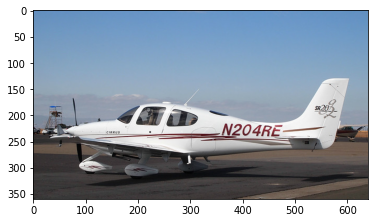

In [26]:
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

image_to_show = Image.open(input_image_filename)
imshow(np.asarray(image_to_show))

### Measure Inference Latency

We will be measuring the inference latency of the SageMaker Neo-compiled model and comparing it to that of the original TensorFlow Lite model. The measurement process will be as follows:

1. Load the image used for inference into a usable input format
2. Perform 25 inferences in a tight loop in order to warm up the Raspberry Pi
3. Perform 50 inferences in a tight loop, recording the time required for each
4. Repeat for the next framework

We first import all necessary packages:

In [27]:
import time
import tensorflow as tf
import dlr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Take a moment to note the versions of DLR (which executes the Neo-compiled model) and TensorFlow being used.

In [28]:
print('TensorFlow version:', tf.__version__)
print('DLR version:', dlr.__version__)

TensorFlow version: 1.14.0
DLR version: 1.3.0


We now read in the image, as it will be used in both benchmarks, and set the values of constants.

In [29]:
NUM_WARMUP = 25
NUM_ACTUAL = 50

image = Image.open(input_image_filename)

Our model expects a input image of size 300x300, so we need to resize our input image.

In [30]:
resized_image = image.resize((300, 300))

With the image read into memory and resized, it is now time to benchmark. 

#### Benchmark TensorFlow Lite

We first measure latency when executing using TensorFlow Lite to get a baseline level of performance. 

In [31]:
def benchmark_tensorflow(image):
    """Measure the p99 and p95 latencies of the TensorFlow Lite model."""
    # Load in the model
    interpreter = tf.lite.Interpreter(model_path='./detect.tflite')
    # Required setup
    interpreter.allocate_tensors()

    # Get a handle so we know where to put the image
    input_details = interpreter.get_input_details()
    x = interpreter.tensor(input_details[0]['index'])
    
    # Our model is quantized, so we must convert the image to uint8
    x = np.array(image).astype('uint8')
        
    # TensorFlow Lite expects for there to be a 4th dimension for
    # batch size
    x = np.expand_dims(x, axis=0)

    
    # Warmup runs
    for i in range(NUM_WARMUP):
        interpreter.invoke()

    latencies = []

    for _ in range(NUM_ACTUAL):
        start_time = time.time()
        interpreter.invoke()
        elapsed_seconds = time.time() - start_time
        elapsed_ms = elapsed_seconds * 1000
        latencies.append(elapsed_ms)

    p99_latency = np.percentile(latencies, 99)
    p95_latency = np.percentile(latencies, 95)
    print(f'95th percentile latency: {p95_latency} ms')
    print(f'99th percentile latency: {p99_latency} ms')
    
    return (p99_latency, p95_latency)
tf_p99_latency, tf_p95_latency = benchmark_tensorflow(resized_image)

95th percentile latency: 413.3474111557007 ms
99th percentile latency: 422.1384835243225 ms


#### Benchmark DLR/Neo

Before we can run the model we compiled with neo, we first need to extract it from the tar.gz

In [32]:
!mkdir ./dlr_model

In [33]:
!tar -xzvf ./compiled-detect.tar.gz --directory ./dlr_model

compiled.meta
libdlr.so
dlr.h
compiled.params
compiled_model.json
compiled.so


Now we measure the performance of our Neo-Compiled model.

In [34]:
def benchmark_dlr(image):
    """Measure the p99 and p95 latencies of the Neo/DLR model."""
    # Load in the model
    model = dlr.DLRModel('./dlr_model', 'cpu', 0)
    x = np.array(image).astype('uint8')

    # Warmup runs
    for i in range(NUM_WARMUP):
        model.run(x)

    latencies = []

    # Actual measurements
    for i in range(NUM_ACTUAL):
        start_time = time.time()
        model.run(x)
        elapsed_seconds = time.time() - start_time
        elapsed_ms = elapsed_seconds * 1000
        latencies.append(elapsed_ms)

    p99_latency = np.percentile(latencies, 99)
    p95_latency = np.percentile(latencies, 95)
    print(f'95th percentile latency: {p95_latency} ms')
    print(f'99th percentile latency: {p99_latency} ms')
    
    return (p99_latency, p95_latency)
neo_p99_latency, neo_p95_latency = benchmark_dlr(resized_image)

2020-10-14 11:43:12,383 INFO Found libdlr.so in model artifact. Using dlr from ./dlr_model/libdlr.so
2020-10-14 11:43:12,383 INFO Found libdlr.so in model artifact. Using dlr from ./dlr_model/libdlr.so


95th percentile latency: 252.2238850593567 ms
99th percentile latency: 252.3707127571106 ms


### Calculate Speedup

In [35]:
print('We see a {0:1.2f}x speedup at the 95th percentile after compiling with SageMaker Neo.'\
      .format(tf_p95_latency / neo_p95_latency))

We see a 1.64x speedup at the 95th percentile after compiling with SageMaker Neo.


> Note: While Neo/DLR uses multithreading by default, TensorFlow Lite typically does not use multiple threads unless explicitly specified. The ability to set `num_threads` through the TensorFlow Lite Python API requires TensorFlow >= 2.3.0, so we are not able to use multithreaded TensorFlow Lite here as we only have TensorFlow Lite 1.14.0.

### Plot Results

With our benchmarking done, it is now time to plot our results. 

Pull together our results:

In [36]:
# TODO(dvisnty): Show speedup instead of raw latency?
labels = ['TensorFlow Lite', 'Neo/DLR']
p95s = np.array([tf_p95_latency, neo_p95_latency]).astype('int')
p99s = np.array([tf_p99_latency, neo_p99_latency]).astype('int')
x = np.arange(2)

Plot the results:

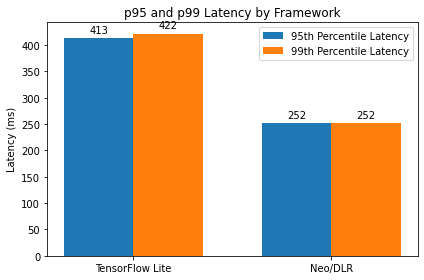

<Figure size 432x288 with 0 Axes>

In [37]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p95s, width, label='95th Percentile Latency')
rects2 = ax.bar(x + width/2, p99s, width, label='99th Percentile Latency')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Latency (ms)')
ax.set_title('p95 and p99 Latency by Framework')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            '{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            va='bottom',
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
plt.savefig('latency_results.png')

## Conclusion

This tutorial showed how to compile an object detection model built in TensorFlow Lite for inference on a Raspberry Pi 3B using SageMaker Neo. It also walked through how to measure the performance benefits of compiling with SageMaker Neo, showing a speedup of approximately 60%.

This notebook is only a brief introduction to the capabilities of SageMaker Neo, and it did not touch on other benefits such as memory usage reduction, portability, or the optimized use of accelerators. To learn more about these features, please visit the [SageMaker Neo documentaiton](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html).